# DAY 12: Beta-Binomial Models

### Machine Learning and Computational Statistics (DSC6232)

#### Instructors: Weiwei Pan, Melanie Fernandez, Pavlos Protopapas

#### Due: August 10th, 2:00 pm Kigali Time

**First name**: _________________________________________________________


**Last name**: _____________

## Learning Goals:

1. be able to apply Beta-Binomial models to determine fair rankings 
2. understand the effect of the prior and evidence in this model
3. be able to interpret the prior and posterior as real-life beliefs

### Load necessary libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### We include auxiliary functions here that we will need to use later 

**No need to read in details!**

In [2]:
def movie_stats(names_df,
                ratings_df,
                movie_name=None,
                movie_name_contains=None,
                verbose=False):
    '''--------  movie_stats
    A function that extracts the total number of ratings and number of likes for a movie
    Input: 
         movie_name (an optional parameter containing the exact name of the movie)
         movie_name_contains (an optional parameter containing part of the movie name)
    Returns: 
         total_ratings (the total number of ratings for a movie)
         likes (the total number of likes for a movie)
    '''
    
    #If given an exact movie name:
    if movie_name is not None:        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains,case=False)].index[0]
        if verbose: print(names_df['movie_name'][movie_index])
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes


def generate_list_top_movies(names_df, ratings_df, n_movies=25):
    '''--------  generate_list_top_movies
    A function that makes a list of movie names and their ratings info,
    based on like-percentage only
    Input: 
         names_df (a dataframe containing the names of the movie)
         ratings_df (a dataframe containing the movie ratings)
         n_movies (an optional parameter indicating the number of movies to return)
    Returns: 
         top_movies (the top movies ranked by like-percentage)
    '''

    likability = []

    #Iterate through all the movie names
    for name in names_df['movie_name'].values:
        #Get ratings info for movie
        total_ratings, likes = movie_stats(names_df, ratings_df, movie_name=name)
        #Add movie info to our list
        likability.append((name, likes, total_ratings, likes / total_ratings))

    #Sort our list of movie info by like-percentage, in descending order
    sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
    #Get the movies with top 25 like-percentage
    top_movies = sorted_likability[:n_movies]

    #Print results of ranking
    print('Top %d Movies' % n_movies)
    print('****************************')
    for movie, likes, total_ratings, likable in top_movies:
        print(movie, ':', likable, '({}/{})'.format(likes, total_ratings))
    return top_movies


def plot_beta_prior(a, b, color, ax):
    '''--------  plot_beta_prior
    A function to visualize a beta pdf on a set of axes
    Input: 
         a (parameter controlling shape of beta prior)
         b (parameter controlling shape of beta prior)
         color (color of beta pdf)
         ax (axes on which to plot pdf)
    Returns: 
         ax (axes with plot of beta pdf)
    '''
    
    #Create a beta-distributed random variable with shape a, b
    rv = sp.stats.beta(a, b)
    #Create values from 0 to 1
    x = np.linspace(0, 1, 100)
    #Plot the beta pdf for values from 0 to 1
    ax.plot(x, rv.pdf(x), '-', lw=2, color=color, label='a=' + str(a) + ', b=' + str(b))
    #Set title, legend etc
    ax.set_title('Beta prior with a=' + str(a) + ', b=' + str(b))
    ax.legend(loc='best')
    
    return ax


def sample_posterior(a, b, likes, ratings, n_samples):
    '''--------  sample_posterior
    A function that samples points from the posterior over a movie's 
    likability, given a binomial likelihood function and beta prior
    Input: 
         a (parameter controlling shape of beta prior)
         b (parameter controlling shape of beta prior)
         likes (the number of likes in likelihood)
         ratings (total number of ratings in likelihood)
         n_samples (number of samples to take from posterior)
    Returns: 
         post_samples (a array of points from the posterior)
    '''
    #Samples points from a beta distribution 
    #(the posterior of a binomial likelihood and a beta prior is a beta distribution!)
    post_samples = np.random.beta(a + likes, b + ratings - likes, n_samples)
    return post_samples


def find_mode(values, num_bins):
    '''--------  find_mode
    A function that approximates the mode of a distribution given a sample from the distribution
    Input: 
         values (samples from the distribution)
         num_bins (number of bins to use in approximating histogram)
    Returns: 
         mode (the approximate mode of the distribution)
    '''
    
    #Make an approximation (histogram) of the distribution using the samples
    bins, edges = np.histogram(values, bins=num_bins)
    #Find the bin in the histogram with the max height
    max_height_index = np.argmax(bins)
    #Find the sample corresponding to the bin with the max height (the mode)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    
    return mode

# Application: building a ranking system of movies based on ratings

The objective is to build a ranking system to recommend movies using ratings from users.

One way of recommending movies is to give a list of movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?

### Read the data and explore

The dataset for this problem is contained in `ratings_df` (below). This dataset contains ratings from 100 users for 1000 movies. The first two columns contain the user and movie IDs. The last column contains a 1 if the user liked the movie, and 0 otherwise. Not every movie is rated by every user (i.e. some movies have more ratings than others).

The names of the movies corresponding to the IDs are provided in `names.df` (below).

Let's first read in the data in the csv file and get acquainted with our data.

In [3]:
# read in the movie ratings data from a csv file
ratings_df = pd.read_csv('https://raw.githubusercontent.com/melaniefp/melaniefp.github.io/master/rwanda_course_files/dataset_4_ratings.txt', delimiter=',')
# print out the first 5 rows of the dataframe
ratings_df.head()

,user_id,movie_id,rating
0,22.0,377.0,0.0
1,62.0,257.0,0.0
2,95.0,546.0,0.0
3,38.0,95.0,1.0
4,63.0,277.0,1.0


In [4]:
# read in the movie names form a csv file
names_df = pd.read_csv('https://raw.githubusercontent.com/melaniefp/melaniefp.github.io/master/rwanda_course_files/movie_names.csv')
# print out the first 5 rows of the dataframe
names_df.head()

,movie_id,movie_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


### Rank movies based on number of positive ratings ("likes")

Let's compare the number of total ratings and "likes" for a couple of movies.

**Exercise 1:** What is the number of total ratings and "likes" for the following movies?
* `Batman Forever (1995)`
* `Unhook the Stars (1996)`
* `Shawshank Redemption, The (1994)`

To help you, the following helper function `compute_n_ratings_and_likes` takes a movie name, and returns total number of ratings, and total number of positive ratings ("likes").

Based on the total number of "likes", which of the following movies would you recommend? Is that a good ranking system?

In [5]:
# call the following function to extract the information
def compute_movie_stats(movie_name=None, movie_name_contains=None):
    total_ratings, likes = movie_stats(names_df, ratings_df,
        movie_name=movie_name, movie_name_contains=movie_name_contains, verbose=True)
    print('total number of ratings:', total_ratings)
    print('number of likes:', likes,'\n')
    return total_ratings, likes

In [6]:
# Step 1: Print the number of ratings and likes for Batman
compute_movie_stats(movie_name_contains='batman')

# Step 2: Print the number of rating and likes for Unhood the Stars and Shawshank Redemption
# COMPLETE

Batman Forever (1995)
total number of ratings: 10.0
number of likes: 1.0 



(10.0, 1.0)

### Rank movies based on percentage of likes

Now, instead of using the total number of likes, we use the total percentage of likes to rank the movies. Each movie will have a *score* associated:
$$ score =\frac{ n_{likes}}{ n_{ratings}} \in [0,1]$$

**Exercise 2:** Print out the top 25 movies ranked by the like-percentage. Do you feel like this list best represents the most "popular" or "beloved" movies in the database? If not, why isn't our ranking system doing a good job (what's wrong with ranking by like-percentage)?

In [7]:
# Step 1: Generate top-list of movies
top_25_movies = generate_list_top_movies(names_df, ratings_df, n_movies=25)

Top 25 Movies
****************************
French Twist (Gazon maudit) (1995) : 1.0 (2.0/2.0)
Exotica (1994) : 1.0 (2.0/2.0)
Three Colors: Red (1994) : 1.0 (12.0/12.0)
Three Colors: White (1994) : 1.0 (8.0/8.0)
Shawshank Redemption, The (1994) : 1.0 (39.0/39.0)
Brother Minister: The Assassination of Malcolm X (1994) : 1.0 (1.0/1.0)
Carlito's Way (1993) : 1.0 (4.0/4.0)
Robert A. Heinlein's The Puppet Masters (1994) : 1.0 (2.0/2.0)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) : 1.0 (2.0/2.0)
Wallace & Gromit: The Best of Aardman Animation (1996) : 1.0 (6.0/6.0)
Maya Lin: A Strong Clear Vision (1994) : 1.0 (1.0/1.0)
Unhook the Stars (1996) : 1.0 (1.0/1.0)
Wrong Trousers, The (1993) : 1.0 (14.0/14.0)
Godfather: Part II, The (1974) : 1.0 (18.0/18.0)
Ridicule (1996) : 1.0 (5.0/5.0)
Pillow Book, The (1995) : 1.0 (2.0/2.0)
When the Cats Away (Chacun cherche son chat) (1996) : 1.0 (3.0/3.0)
unknown : 1.0 (2.0/2.0)
Once Upon a Time... When We Were Colored (1995) : 1.0 (2.0/2.0)
Ass

### Exploring the effect of prior beliefs

Recall that we can prejudice our models (if we don't like their results) by building in some prior beliefs about the model parameters. In this case, our model parameter is "the likability of a movie". So let's encode some prior beliefs for what we think are reasonable values for "likability". To keep things simple, we will restrict ourselves to using beta priors to model our beliefs about "likability".

We have built for you a few helpful functions: one to help you visualize the pdf for various beta priors, one for approximating the posterior using samples, and one for calculating the mode of a distribution (given by some sampled values).

First, let's explore the shapes of various beta pdfs and let's interpret these shapes as prior beliefs.

**Exercise 3:** The following is a set of five differe beta distributions. Describe in words what prior belief about the movie corresponds to each prior. Which beta prior encodes an appropriate belief about likability? Why?

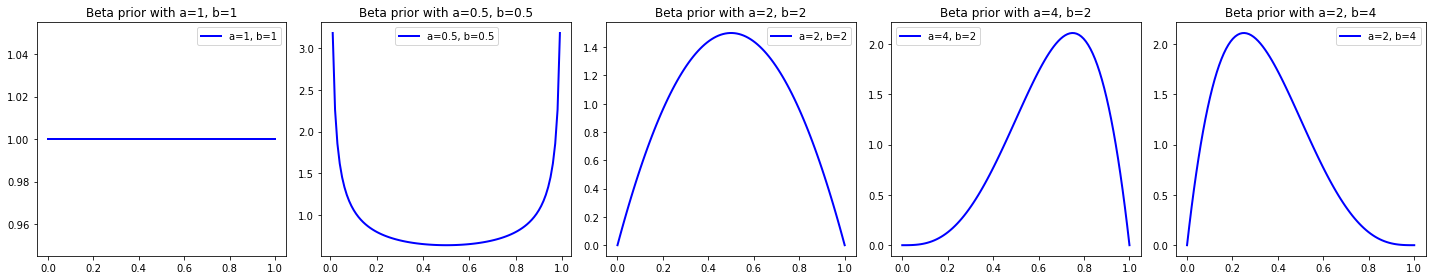

In [8]:
# Step 1: A list of beta distribution shapes to try out
beta_shapes = [(1, 1), (0.5, 0.5), (2, 2), (4, 2), (2, 4)]

# Step 2: Length of the list of shapes
n = len(beta_shapes)

# Step 3: Plot all the beta pdfs in a row
fig, ax = plt.subplots(1, n, figsize=(20, 4))

# Step 4: Start the index of the current subplot at 0
ax_ind = 0

# Step 5: Iterate through all the shapes
for a, b in beta_shapes:
    # Step 5a: Plot the beta pdf for a particular shape
    plot_beta_prior(a, b, 'blue', ax[ax_ind])

    # Step 5b: Increment the subplot index
    ax_ind += 1
    
plt.tight_layout()    
plt.show() 


Let's then look at the effect of the priors on the posterior of likability for a specific movie.

**Exercise 4:** For the movie the "French Twist", print out the posterior of the Beta-Binomial model for each of five priors in Exercise 3. 

Describe in words what belief about the movie corresponds to each posterior.

Describe the effect of the prior on the posterior distribution. 

In [15]:
# Step 1: Get the name of the first movie in the previous top-25 list
movie_name = top_25_movies[0][0]

# Step 2: Get the ratings info for the first movie in the top 25 list
likes = top_25_movies[0][1]
total_ratings = top_25_movies[0][2]
likability = top_25_movies[0][3]

# Step 3: Print movie info
print('{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings))

French Twist (Gazon maudit) (1995): 1.0 (2.0/2.0)


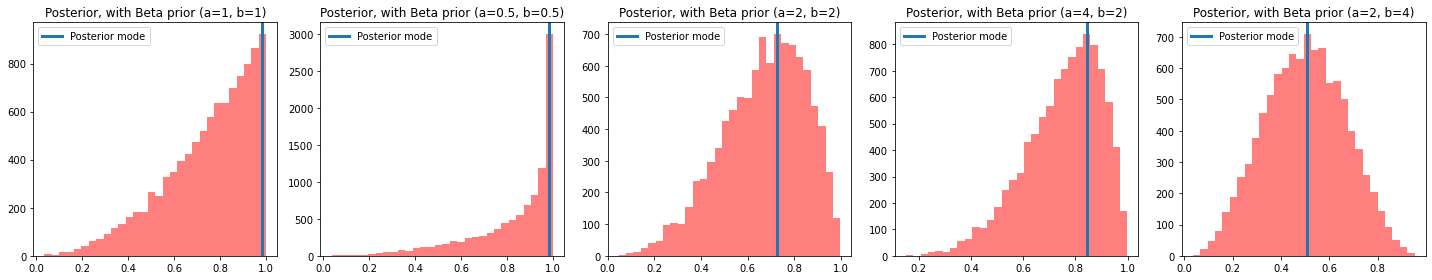

In [16]:
# Step 4: Number of samples to use when approximating our posterior
n_samples = 10000

# Step 5: Plot the posterior corresponding to each prior
fig, ax = plt.subplots(1, n, figsize=(20, 4))

# Step 6: Start the index of the current subplot at 0
ax_ind = 0

# Step 7: Iterate through all the shapes
for a, b in beta_shapes:   
    # Step 7a: Draw samples from the posterior corresponding to a particular beta prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)

    # Step 7b: Approximate the posterior with a histogram of these samples
    ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)

    # Step 7c: Find the approximate mode of the posterior
    mode = find_mode(post_samples, 30)

    # Step 7d: Plot the mode as a vertical line
    ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')
    
    # Step 7e: Set title, legends etc
    ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
    ax[ax_ind].legend(loc='best')

    # Step 7f: Increment the subplot index
    ax_ind += 1

plt.tight_layout()
plt.show() 

**Exercise 5:** For the movie the "Shawshank Redemption", print out the posterior of the Beta-Binomial model for each of five priors in Exercise 3. 

Describe in words what belief about the movie corresponds to each posterior.

Describe the effect of the prior on the posterior distribution. 

Compare the posteriors for "Shawshank Redemption" to those for "French Twist", explain why the posteriors for these movies look different when the same priors are used. Relate your answers to the concepts from lecture.

In [13]:
# Step 1: Get the name of the first movie in the previous top-25 list
movie_name = top_25_movies[4][0]

# Step 2: Get the ratings info for the first movie in the top 25 list
likes = top_25_movies[4][1]
total_ratings = top_25_movies[4][2]
likability = top_25_movies[4][3]

# Step 3: Print movie info
print('{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings))

Shawshank Redemption, The (1994): 1.0 (39.0/39.0)


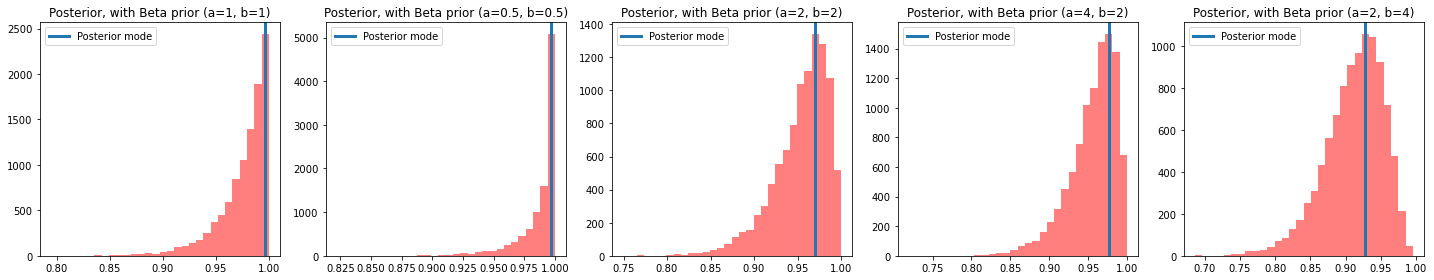

In [14]:
# Step 4: Number of samples to use when approximating our posterior
n_samples = 10000

# Step 5: Plot the posterior corresponding to each prior
fig, ax = plt.subplots(1, n, figsize=(20, 4))

# Step 6: Start the index of the current subplot at 0
ax_ind = 0

# Step 7: Iterate through all the shapes
for a, b in beta_shapes:   
    # Step 7a: Draw samples from the posterior corresponding to a particular beta prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)

    # Step 7b: Approximate the posterior with a histogram of these samples
    ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)

    # Step 7c: Find the approximate mode of the posterior
    mode = find_mode(post_samples, 30)

    # Step 7d: Plot the mode as a vertical line
    ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')
    
    # Step 7e: Set title, legends etc
    ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
    ax[ax_ind].legend(loc='best')

    # Step 7f: Increment the subplot index
    ax_ind += 1

plt.tight_layout()
plt.show() 

### Implement a ranking system that takes prior beliefs into account

Let's choose a reasonable beta prior and build a list of top 25 movies that you would recommend to a new user based on the posterior mode.

**Exercise 6:**
In what important ways is our top 25 list using the posterior mode different from our top 25 list using the like-percent?

Describe the possible benefits of using the posterior mode to rank movies instead of the like-percentage? Relate your answers to the concepts from lecture.

Describe the possible draw-backs of using the posterior mode to rank movies. Relate your answers to the concepts from lecture.

In [17]:
# Step 1: Choose a beta prior that encodes a reasonable belief about likability 
a = 2 
b = 2

# Step 2: Make a list of movie names and their ratings info
likability = []

# Step 3: Iterate through all the movie names
for name in names_df['movie_name'].values:
    # Step 3a: Get ratings info for movie
    total_ratings, likes = movie_stats(names_df, ratings_df, movie_name=name)

    # Step 3b: Approximate the posterior given the ratings info and the prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)

    # Step 3c: Approximate posterior mode
    mode = find_mode(post_samples, 30)

    # Step 3d: Add movie info to our list
    likability.append((name, likes, total_ratings, mode))

# Step 4: Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  

# Step 5: Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

# Step 6: Print results of ranking
print('Top 25 Movies')
print('****************************')
for movie, likes, total_ratings, likable in top_25_movies:
    print(movie, ':', likable, '({}/{})'.format(likes, total_ratings))

Top 25 Movies
****************************
Shawshank Redemption, The (1994) : 0.9779666956978554 (39.0/39.0)
Manchurian Candidate, The (1962) : 0.9588128998405081 (17.0/17.0)
Godfather: Part II, The (1974) : 0.9566640610901816 (18.0/18.0)
Glory (1989) : 0.9566540396224947 (17.0/17.0)
Raiders of the Lost Ark (1981) : 0.9479405318654763 (47.0/49.0)
Killing Fields, The (1984) : 0.9411580252240153 (14.0/14.0)
Cool Hand Luke (1967) : 0.9393717505554792 (20.0/20.0)
Three Colors: Red (1994) : 0.9336294486785537 (12.0/12.0)
Wrong Trousers, The (1993) : 0.9306864710521451 (14.0/14.0)
Local Hero (1983) : 0.9279652737452357 (10.0/10.0)
High Noon (1952) : 0.9173130473841598 (11.0/11.0)
Thin Man, The (1934) : 0.9171141909337602 (8.0/8.0)
Vertigo (1958) : 0.9169015753298977 (22.0/23.0)
Casablanca (1942) : 0.9162055343445275 (22.0/23.0)
Taxi Driver (1976) : 0.9096585576973436 (17.0/18.0)
Alien (1979) : 0.9037838683280508 (28.0/30.0)
Usual Suspects, The (1995) : 0.9022935772851326 (27.0/29.0)
Third Ma

---